In [34]:
import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from create_datasets import *
from sklearn.metrics import accuracy_score

In [35]:
final_edges = np.load('../datasets/final_edges.dump', allow_pickle=True)
data = generate_fingerprints(final_edges)

  0%|          | 0/87153 [00:00<?, ?it/s]

  0%|          | 0/87153 [00:00<?, ?it/s]

  0%|          | 0/87153 [00:00<?, ?it/s]

/home2/kanakala.ganesh/ML4NS/src/create_datasets.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  i[2]


0it [00:00, ?it/s]

In [55]:

class ACNN(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        n_classes: number of classes
        
    """

    def __init__(self, in_channels, out_channels, att_channels, n_len_seg, n_classes, device, verbose=False, sf = False):
        super(ACNN, self).__init__()
        
        self.n_len_seg = n_len_seg
        self.n_classes = n_classes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.att_channels = att_channels

        self.device = device
        self.verbose = verbose
        self.sf =sf

        # (batch, channels, length)
        self.cnn = nn.Conv1d(in_channels=self.in_channels, 
                            out_channels=self.out_channels, 
                            kernel_size=16, 
                            stride=4)

        self.W_att_channel = nn.Parameter(torch.randn(self.out_channels, self.att_channels))
        self.v_att_channel = nn.Parameter(torch.randn(self.att_channels, 1))

        self.dense = nn.Linear(out_channels, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):

        self.n_channel, self.n_length = x.shape[-2], x.shape[-1]
        assert (self.n_length % self.n_len_seg == 0), "Input n_length should divided by n_len_seg"
        self.n_seg = self.n_length // self.n_len_seg

        out = x
        # (n_samples, n_channel, n_length) -> (n_samples, n_length, n_channel)
        out = out.permute(0,2,1)

        # (n_samples, n_length, n_channel) -> (n_samples*n_seg, n_len_seg, n_channel)
        out = out.view(-1, self.n_len_seg, self.n_channel)

        # (n_samples*n_seg, n_len_seg, n_channel) -> (n_samples*n_seg, n_channel, n_len_seg)
        out = out.permute(0,2,1)

        # cnn
        out = self.cnn(out)

        # global avg, (n_samples*n_seg, out_channels)
        out = out.mean(-1)

        out = out.view(-1, self.n_seg, self.out_channels)
        # self attention
        e = torch.matmul(out, self.W_att_channel)
        e = torch.matmul(torch.tanh(e), self.v_att_channel)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        gama = torch.div(n1, n2)
        out = torch.sum(torch.mul(gama, out), 1)
        out = self.dense(out)
        if self.sf == True:
            out = self.softmax(out)
        return out

In [56]:
Net = ACNN()

TypeError: __init__() missing 6 required positional arguments: 'in_channels', 'out_channels', 'att_channels', 'n_len_seg', 'n_classes', and 'device'

In [57]:
class FullNet(nn.Module):
    def __init__(self, finger_print_model, graph_embedding_model, combined_model):
        super().__init__()
        self.FP_model = finger_print_model
        self.GE_model = graph_embedding_model
        self.CB_model = combined_model
    
    def forward(self, fp, ge):
        fp_out = self.FP_model(fp)
        ge_out = self.GE_model(ge)
        inp = torch.cat((fp_out, ge_out), 1)
        inp = inp.unsqueeze(1)
        out = self.CB_model(inp)
        return out

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device= 'cpu'

cuda


In [59]:
dataset = LinkDataset(data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train , test = torch.utils.data.random_split(dataset, [train_size, test_size])
BATCH_SIZE = 256
trainloader = DataLoader(train, num_workers = 16, batch_size= BATCH_SIZE)
testloader = DataLoader(test, num_workers = 16, batch_size= BATCH_SIZE)

In [63]:
model = FullNet(ACNN(1, 256, 32, 1024, 256, device), 
                ACNN(1, 256, 32, 256, 256, device), 
                ACNN(1, 256, 32, 512, 2, device, sf=True))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-6
                            )
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [64]:
out = model(torch.rand(32, 1, 1024).float().to(device), torch.rand(32, 1, 256).float().to(device))

In [66]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| FP_model.W_att_channel |    8192    |
| FP_model.v_att_channel |     32     |
|  FP_model.cnn.weight   |    4096    |
|   FP_model.cnn.bias    |    256     |
| FP_model.dense.weight  |   65536    |
|  FP_model.dense.bias   |    256     |
| GE_model.W_att_channel |    8192    |
| GE_model.v_att_channel |     32     |
|  GE_model.cnn.weight   |    4096    |
|   GE_model.cnn.bias    |    256     |
| GE_model.dense.weight  |   65536    |
|  GE_model.dense.bias   |    256     |
| CB_model.W_att_channel |    8192    |
| CB_model.v_att_channel |     32     |
|  CB_model.cnn.weight   |    4096    |
|   CB_model.cnn.bias    |    256     |
| CB_model.dense.weight  |    512     |
|  CB_model.dense.bias   |     2      |
+------------------------+------------+
Total Trainable Params: 169826


169826

In [76]:
def eval(model,testloader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    for fp, ge, label in testloader:
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        test_loss+=loss.item()
        for i in range(len(output)):
            pred = output[i].argmax().item()
            true = label[i].argmax().item()
            preds.append(pred)
            trues.append(true)
    model.train()
    print("Accuracy", accuracy_score(preds, trues))
    return accuracy_score(preds, trues), test_loss / len(testloader)

In [77]:
train_losses = []
test_losses = []
num_epochs= 50
best_acc = 0.0
acc_list = []
for epoch in tqdm(range(1, num_epochs)):
    train_loss = 0.0
    model.train()
    batch_id = 0
    for fp, ge, label in trainloader:
        batch_id +=1
        
        optimizer.zero_grad()
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    
        print(f'Epoch:{epoch} batch {batch_id}/{len(trainloader)} loss:{loss.item()}', end='\r')
    
    acc, test_loss = eval(model, testloader)
    acc_list.append(acc)

    if acc > best_acc:
        best_acc = acc
        print("Improved Accuracy is", acc )
        torch.save(model, 'SAVED_MODELS/ACNN-bestmodel_1.pt')
        with open('SAVED_MODELS/ACNN-bestmodel_1.txt', 'w') as f:
            print(model.eval() , "Accuracy" , acc, file=f)

#     else:
#         model = torch.load('SAVED_MODELS/ACNN-bestmodel_1.pt')
    
    print()
    print("Train loss: ",train_loss/len(trainloader))
    print("Test  loss: ",test_loss)
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss)

  0%|          | 0/49 [00:00<?, ?it/s]

Accuracy 0.66381733692846080.6628836989402771
Improved Accuracy is 0.6638173369284608

Train loss:  0.6638155704016214
Test  loss:  0.6635519361150437
Accuracy 0.66381733692846080.6606324315071106

Train loss:  0.661420450760768
Test  loss:  0.6612447379291921
Accuracy 0.66381733692846080.6584118008613586

Train loss:  0.6590228436630724
Test  loss:  0.6589559135229691


KeyboardInterrupt: 

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def get_performance(model, testloader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    for fp, ge, label in testloader:
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        test_loss+=loss.item()
        for i in range(len(output)):
            pred = output[i].argmax().item()
            true = label[i].argmax().item()
            preds.append(pred)
            trues.append(true)
    model.train()
    print("Accuracy", accuracy_score(preds, trues))
    print(classification_report(trues, preds, labels=[0,1]))
    print()
    cm = confusion_matrix(trues, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, np.array([0,1]))
    disp.plot()
    plt.show()

Accuracy 0.6638173369284608
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     11571
           1       0.00      0.00      0.00      5860

    accuracy                           0.66     17431
   macro avg       0.33      0.50      0.40     17431
weighted avg       0.44      0.66      0.53     17431




/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

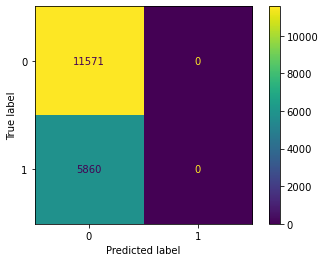

In [79]:
get_performance(model, testloader)